In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import cProfile

deepp = deep_properties()

##### Creating random grid-cells with Krycklan pF, z, and Ksat parameters

In [3]:
# INITIALIZING
max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size
shape = (10, 10)
deep_id = np.random.randint(1, 2, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']
print('number of grid-cells:', len(deep_zs))
print('deep_zs[0]', deep_zs[0])
print('deep_pFs[0]', deep_pFs[0])
print('deep_ksats[0]', deep_ksats[0])

number of grid-cells: 90000
deep_zs[0] [ -1.2  -3.8  -4.   -5.4 -21. ]
deep_pFs[0] {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
deep_ksats[0] [1.e-07 3.e-05 1.e-08 3.e-05 1.e-04]


##### h_to_cellmoist functions

In [4]:
# Original function by Kersti
def h_to_cellmoist(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m3 m-3]
            'ThetaR' (array): residual water content [m3 m-3]
            'alpha' (array): air entry suction [cm-1]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m3 m-3]

    Kersti Haahti, Luke 8/1/2018
    """
    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)

    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

# Vectorized function allowing simulataneous computation for multiple cells. Still 'h' comes in as float (i.e. needs for-loop)
def h_to_cellmoist_vectorized_0(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (np.ndarray):
            dict
                'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                'n' (np.ndarray): pore size distribution [-]
        h (float): pressure head [m]
        dz (np.ndarray): soil compartment thichness, node in center [m]
    Returns:
        Wsto (np.ndarray): Total volumetric water content of cell for given gwl
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + np.abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h[0]) < dz/2)

    if Ts.shape[1] == 1:
        ixx = (np.array([0]), np.array([0]))  # Single index for 2D case
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + np.abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])
    # from vwc to total water content
    Wsto = theta * dz
    Wsto = np.nansum(Wsto, axis=1)
    
    return Wsto

def h_to_cellmoist_vectorized_1(Ts, Tr, alfa, n, gwl, z_mid, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (np.ndarray):
            dict
                'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                'n' (np.ndarray): pore size distribution [-]
        h (float): pressure head [m]
        dz (np.ndarray): soil compartment thichness, node in center [m]
    Returns:
        Wsto (np.ndarray): Total volumetric water content of cell for given gwl
    """

    # water retention parameters
    #Ts = np.array(pF['ThetaS'])
    #Tr = np.array(pF['ThetaR'])
    #alfa = np.array(pF['alpha'])
    #n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    for i in range(len(gwl)):
        g = gwl[i]
        h = g - z_mid

        # moisture based on cell center head
        x = np.minimum(h, 0)
        theta = Tr + (Ts - Tr) / (1 + np.abs(alfa * 100 * x)**n)**m

        # correct moisture of partly saturated cells
        ix = np.where(np.abs(h[0]) < dz/2)

        if Ts.shape[1] == 1:
            ixx = (np.array([0]), np.array([0]))  # Single index for 2D case
        else:
            ixx = ix
        # moisture of unsaturated part
        x[ix] = -(dz[ix]/2 - h[ix]) / 2
        theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + np.abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
        # total moisture as weighted average
        theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    # from vwc to total water content
    Wsto = theta * dz
    Wsto = np.nansum(Wsto, axis=1)
    
    return Wsto

# Vectorized function allowing simulataneous computation for multiple cells and 'h's
def h_to_cellmoist_vectorized_2(pF, gwl, z_mid, dz):
    r""" Fully vectorized cell moisture calculation using van Genuchten-Mualem model.

    Args:
        pF (dict): Soil parameters
            'ThetaS' (np.ndarray): saturated water content [m³/m³]
            'ThetaR' (np.ndarray): residual water content [m³/m³]
            'alpha' (np.ndarray): air entry suction [cm⁻¹]
            'n' (np.ndarray): pore size distribution [-]
        gwl (np.ndarray): Groundwater levels below surface, shape (n_gwl,)
        z_mid (np.ndarray): Depth of layer midpoints, shape (n_cells, n_layers)
        dz (np.ndarray): Layer thickness, shape (n_cells, n_layers)

    Returns:
        theta (np.ndarray): Total volumetric water content of cell for each gwl, shape (n_cells, n_gwl)
    """

    # Extract van Genuchten parameters
    Ts = pF['ThetaS']  # Shape: (n_cells, n_layers)
    Tr = pF['ThetaR']
    alpha = pF['alpha']
    n = pF['n']
    m = 1.0 - 1.0 / n

    # Expand gwl for broadcasting
    gwl = gwl[:, None, None]  # Shape: (n_gwl, 1, 1)

    # Compute pressure head at each layer midpoint
    # here h becomes 3D matrix...
    h = gwl - z_mid  # Shape: (n_gwl, n_cells, n_layers)

    # Compute moisture based on pressure head using van Genuchten model
    h_clipped = np.minimum(h, 0)  # Apply only to negative pressure heads
    theta = Tr + (Ts - Tr) / (1 + np.abs(alpha * 100 * h_clipped) ** n) ** m  # Shape: (n_gwl, n_cells, n_layers)

    # Identify partially saturated cells
    half_dz = dz / 2
    partially_saturated = np.abs(h) < half_dz  # Shape: (n_gwl, n_cells, n_layers)

    # Compute weighted moisture only where needed
    if np.any(partially_saturated):  # Check to avoid unnecessary calculations
        x_unsat = -(half_dz - h) / 2  # Unsaturated thickness
        theta_unsat = Tr + (Ts - Tr) / (1 + np.abs(alpha * 100 * x_unsat) ** n) ** m

        weighted_theta = (theta_unsat * (half_dz - h) + Ts * (half_dz + h)) / dz
        theta[partially_saturated] = weighted_theta[partially_saturated]

    # Convert to water storage per layer
    theta *= dz  # Shape: (n_gwl, n_cells, n_layers)

    # Sum across layers to get total water storage
    Wsto = theta.sum(axis=2)  # Shape: (n_gwl, n_cells)

    return Wsto.T  # Shape: (n_cells, n_gwl)


def h_to_cellmoist_vectorized_3(pF, gwl, z_mid, dz):
    r""" Fully vectorized cell moisture calculation using van Genuchten-Mualem model.

    Args:
        pF (dict): Soil parameters
            'ThetaS' (np.ndarray): saturated water content [m³/m³]
            'ThetaR' (np.ndarray): residual water content [m³/m³]
            'alpha' (np.ndarray): air entry suction [cm⁻¹]
            'n' (np.ndarray): pore size distribution [-]
        gwl (np.ndarray): Groundwater levels below surface, shape (n_gwl,)
        z_mid (np.ndarray): Depth of layer midpoints, shape (n_cells, n_layers)
        dz (np.ndarray): Layer thickness, shape (n_cells, n_layers)

    Returns:
        theta (np.ndarray): Total volumetric water content of cell for each gwl, shape (n_cells, n_gwl)
    """

    # Extract van Genuchten parameters
    Ts = pF['ThetaS']  # Shape: (n_cells, n_layers)
    Tr = pF['ThetaR']
    alpha = pF['alpha']
    n = pF['n']
    m = 1.0 - 1.0 / n

    # Expand gwl for broadcasting
    gwl = gwl[:, None, None]  # Shape: (n_gwl, 1, 1)

    # Compute pressure head at each layer midpoint
    # here h becomes 3D matrix...
    h = gwl - z_mid  # Shape: (n_gwl, n_cells, n_layers)

    # Compute moisture based on pressure head using van Genuchten model
    h_clipped = np.minimum(h, 0)  # Apply only to negative pressure heads
    #Tr = Tr.astype(float32)

    theta = vanGenuchten_to_theta(Tr, Ts, alpha, n, m, h_clipped)
    #theta = Tr + (Ts - Tr) / (1 + np.abs(alpha * 100 * h_clipped) ** n) ** m  # Shape: (n_gwl, n_cells, n_layers)

    # Identify partially saturated cells
    half_dz = dz / 2
    partially_saturated = np.abs(h) < half_dz  # Shape: (n_gwl, n_cells, n_layers)

    # Compute weighted moisture only where needed
    if np.any(partially_saturated):  # Check to avoid unnecessary calculations
        x_unsat = -(half_dz - h) / 2  # Unsaturated thickness
        theta_unsat = Tr + (Ts - Tr) / (1 + np.abs(alpha * 100 * x_unsat) ** n) ** m

        weighted_theta = (theta_unsat * (half_dz - h) + Ts * (half_dz + h)) / dz
        theta[partially_saturated] = weighted_theta[partially_saturated]

    # Convert to water storage per layer
    theta *= dz  # Shape: (n_gwl, n_cells, n_layers)

    # Sum across layers to get total water storage
    Wsto = theta.sum(axis=2)  # Shape: (n_gwl, n_cells)

    return Wsto.T  # Shape: (n_cells, n_gwl)

@jit
def vanGenuchten_to_theta(Tr, Ts, alpha, n, m, h):
    return Tr + (Ts - Tr) / (1 + np.abs(alpha * 100 * h) ** n) ** m

NameError: name 'jit' is not defined

##### Demonstrating the use of the original (non-vectorized) function for one grid-cell

         7444 function calls in 0.034 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.018    0.000    0.020    0.000 3764113651.py:2(h_to_cellmoist)
        1    0.001    0.001    0.033    0.033 <string>:1(<listcomp>)
        1    0.000    0.000    0.033    0.033 <string>:1(<module>)
      620    0.000    0.000    0.000    0.000 multiarray.py:346(where)
     1860    0.001    0.000    0.001    0.000 {built-in method builtins.abs}
        1    0.000    0.000    0.034    0.034 {built-in method builtins.exec}
      620    0.000    0.000    0.000    0.000 {built-in method builtins.len}
      620    0.000    0.000    0.000    0.000 {built-in method builtins.max}
      620    0.012    0.000    0.012    0.000 {built-in method builtins.sum}
     2480    0.001    0.000    0.001    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




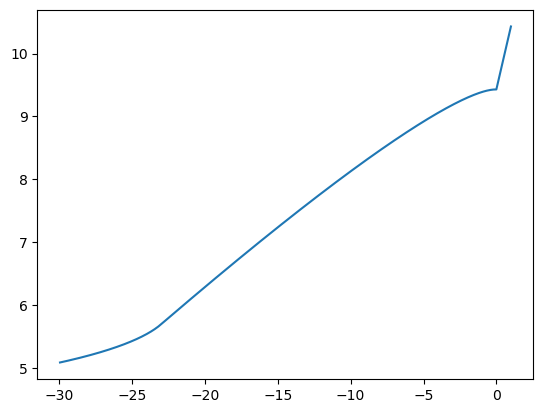

In [4]:
# parameters of one grid-cell
z = deep_zs[0]
pF = deep_pFs[0]

# groundwater levels
step = -0.05
gwl = np.arange(1, -30, step)

# 1D grid
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses
# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine = (np.arange(0, min(z), + step) + step).astype(np.float64)
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)

# creating index ix to be used to create pF_fine
ix = np.zeros(len(z_fine), dtype=np.float64)
for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})

Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]
cProfile.run('[sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) + max(0.0,g) for g in gwl]')

plt.plot(gwl, Wsto_deep)

##### Demonstrating the use of the vectorized function that allows computation of multiple grid-cells (still looping over groundwater levels). Note that the creation of grid differs slightly from above. It creates the grid from 0 to global minimum (of all grid-cells).. Will correct later.

length of computed cells: 100
         14274 function calls in 0.659 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.588    0.001    0.646    0.001 3179223540.py:47(h_to_cellmoist_vectorized_0)
        1    0.013    0.013    0.659    0.659 <string>:1(<listcomp>)
        1    0.000    0.000    0.659    0.659 <string>:1(<module>)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
      620    0.000    0.000    0.009    0.000 fromnumeric.py:2177(sum)
      620    0.000    0.000    0.009    0.000 fromnumeric.py:71(_wrapreduction)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
      620    0.000    0.000    0.000    0.000 multiarray.py:1080(copyto)
        1    0.000    0.000    0.000    0.000 multiarray.py:153(concatenate)
      620    0.000    0.000    0.000    0.000 multiarray.py:346(where)
      620    0.000    0.000    0.000    0.000 nanfunctions.py

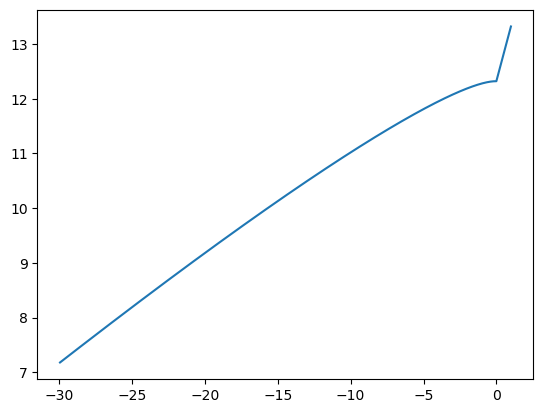

In [6]:
# now with multiple grid-cells (vectorized function)
z = deep_zs
pF = deep_pFs
print('length of computed cells:', len(z))

# groundwater levels
step = -0.05
gwl = np.arange(1, -30, step)

# 1D grid
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)

pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)


Wsto_deep = np.stack([h_to_cellmoist_vectorized_0(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T
cProfile.run('np.stack([h_to_cellmoist_vectorized_0(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T')

plt.plot(gwl, Wsto_deep[0])

In [9]:
# now with multiple grid-cells (vectorized function)
z = deep_zs
pF = deep_pFs
print('length of computed cells:', len(z))

# groundwater levels
step = -0.05
gwl = np.arange(1, -30, step)

# 1D grid
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)

pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

Ts = pF_fine['ThetaS']
Tr = pF_fine['ThetaR']
alfa = pF_fine['alpha']
n = pF_fine['n']

Wsto_deep = h_to_cellmoist_vectorized_1(Ts, Tr, alfa, n, gwl, z_mid_fine, dz_fine)
#cProfile.run('h_to_cellmoist_vectorized_1(pF_fine['ThetaS'], pF_fine['ThetaR'], pF_fine['alpha'], pF_fine['n'], gwl, z_mid_fine, dz_fine)')

#plt.plot(gwl, Wsto_deep[0])

length of computed cells: 100


##### Demonstrating the use of further vectorized function where groundwater levels are also vectorized

length of computed cells: 100
         15 function calls in 1.715 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.026    1.026    1.693    1.693 3212976444.py:151(h_to_cellmoist_vectorized_3)
        1    0.658    0.658    0.658    0.658 3212976444.py:207(vanGenuchten_to_theta)
        1    0.022    0.022    1.715    1.715 <string>:1(<module>)
        1    0.000    0.000    0.008    0.008 _methods.py:47(_sum)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2317(_any_dispatcher)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:2322(any)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:71(_wrapreduction)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
        1    0.000    0.000    0.000    0.000 serialize.py:30(_numba_unpickle)
        1    0.000    0.000    1.715    1.715 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.

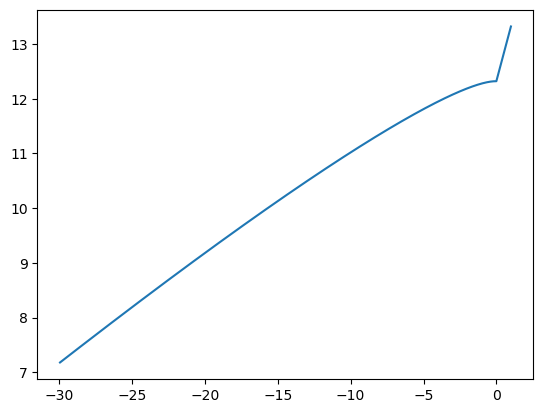

In [13]:
z = deep_zs
pF = deep_pFs
print('length of computed cells:', len(z))

# groundwater levels
step = -0.05
gwl = np.arange(1, -30, step)

dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

Wsto_deep = h_to_cellmoist_vectorized_2(pF_fine, gwl, z_mid_fine, dz_fine) + np.maximum(0.0, gwl)

plt.plot(gwl, Wsto_deep[0])

cProfile.run('h_to_cellmoist_vectorized_3(pF_fine, gwl, z_mid_fine, dz_fine) + np.maximum(0.0, gwl)')